**Exploratory Earthquake Prediction Study for Istanbul**

This notebook provides a walkthrough on our process for our Istanbul Earthquake study. Further details can also be found on the complimentary project report.
In order for this notebook to work correctly, it requires mounting google drive.
Demonstrative dataset can be found within the submission under the name "demo_data.txt". This file should be added to path "/content/drive/MyDrive/earthquake_project/raw_txt" in the google colab drive folders after running the first cell.


Sections of the notebook include:



*   Importing & Cleaning Data
*   EDA
*   Feature Engineering
*   Anomaly Detection
*   Machine Learning Model Training & Evaluation

There are added Expeirmental Notes, indicated with a star emoji "⭐". These notes provide an insigth on our decision steps, implementation challenges and comments on processes.






In [39]:
#Visualisation library
!pip install geopandas
#Tensorflow is pre-installed in colab. Yet is an error arises it can be manually installed by running this command.
#!pip install tensorflow

#Importing & Cleaning Data

In [40]:
# Setup

#Mounting Google Drive for storage
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
from datetime import datetime, timedelta
from math import log10, sqrt
import re

# Set your Drive path
base_path = "/content/drive/MyDrive/earthquake_project"
raw_folder = os.path.join(base_path, "raw_txt")
os.makedirs(raw_folder, exist_ok=True)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [41]:
#Load .txt file into Pandas DataFrame

def parse_txt_to_df(filepath):
  #Common Encoding for Windows files
    with open(filepath, 'r', encoding='cp1252') as f:
        lines = f.readlines()

    records = []
    for line in lines:
        if not line.strip(): continue
        try:
            parts = line.strip().split()
            if len(parts) < 10: continue
            No = parts[0]
            EqCode = parts[1]
            Date = parts[2]
            Time = parts[3]
            Latitude = parts[4]
            Longitude = parts[5]
            DepthKM = parts[6]
            Magnitude = parts[7]
            MD = parts[8]
            ML = parts[9]
            Mw = parts[10]
            Ms = parts[11]
            Mb = parts[12]
            EqType = parts[13]
            EqLocation = ' '.join(parts[14:])
            x=Time.split(':')
            z=x[2].split('.')
            y=x[0]+x[1]+z[0]
            Day=Date.split('.')[2]
            Month=Date.split('.')[1]
            Year=Date.split('.')[0]
            datetime_str = Year+Month+Day+ y
            DateTime = datetime.strptime(datetime_str, '%Y%m%d%H%M%S')
            records.append([No, EqCode,	Date,	Time, DateTime, Day, Month, Year, Latitude,	Longitude,	DepthKM,	Magnitude,	MD,	ML,	Mw,	Ms,	Mb,	EqType, EqLocation])
        except:
            continue

    df = pd.DataFrame(records, columns=["No",  "EqCode",	"Date",	"Time", "DateTime", "Day", "Month", "Year", "Latitude",	"Longitude",	"Depth(km)",	"Magnitude",	"MD",	"ML",	"Mw",	"Ms",	"Mb",	"EqType", "EqLocation"])
    df = df.sort_values("Date").reset_index(drop=True)

        # Convert 'Magnitude', 'Latitude', 'Longitude', and 'Depth(km)' to numeric, coercing errors to NaN
    for col in ['Magnitude', 'Latitude', 'Longitude', 'Depth(km)', 'MD', 'ML', 'Mw', 'Ms', 'Mb']:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    return df


In [42]:
#Merge All Files

all_files = glob.glob(os.path.join(raw_folder, "*.txt"))
merged_df = pd.DataFrame()

for file in all_files:
    df = parse_txt_to_df(file)
    print(f"{os.path.basename(file)}: {len(df)} records")
    merged_df = pd.concat([merged_df, df], ignore_index=True)

# Drop duplicates
merged_df.drop_duplicates("DateTime", inplace=True)

# Save cleaned merged file
merged_df.to_csv(os.path.join(base_path, "master_earthquake_data.csv"), index=False)

#Total numbers of Eq, rows on the table
print(f"Row count of merged data {len(merged_df)}")
#First rows of the table
merged_df.head()


20200101_20250528_2.0_9.0_31_597.txt: 854 records
20050101_20100101_2.0_9.0_58_441.txt: 1091 records
20100101_20150101_2.0_9.0_36_254.txt: 1449 records
20150101_20200101_2.0_9.0_42_306.txt: 1306 records
Row count of merged data 4698


,No,EqCode,Date,Time,DateTime,Day,Month,Year,Latitude,Longitude,Depth(km),Magnitude,MD,ML,Mw,Ms,Mb,EqType,EqLocation
0,000854,20200101190154,2020.01.01,19:01:54.89,2020-01-01 19:01:54,01,01,2020,40.8197,28.9303,13.1,2.1,0.0,2.1,0.0,0.0,0.0,Ke,MARMARA DENIZI
1,000853,20200102111840,2020.01.02,11:18:40.87,2020-01-02 11:18:40,02,01,2020,40.8308,28.3470,7.5,2.9,0.0,2.9,0.0,0.0,0.0,Ke,MARMARA DENIZI
2,000852,20200104171302,2020.01.04,17:13:02.76,2020-01-04 17:13:02,04,01,2020,40.7703,29.0457,15.0,3.2,0.0,3.2,0.0,0.0,0.0,Ke,CINARCIK ACIKLARI-YALOVA (MARMARA DENIZI)
3,000851,20200105201949,2020.01.05,20:19:49.98,2020-01-05 20:19:49,05,01,2020,40.7808,29.0600,8.8,2.1,0.0,2.1,0.0,0.0,0.0,Ke,CINARCIK ACIKLARI-YALOVA (MARMARA DENIZI)
4,000849,20200111033607,2020.01.11,03:36:07.54,2020-01-11 03:36:07,11,01,2020,40.6997,27.4065,9.3,2.1,0.0,2.1,0.0,0.0,0.0,Ke,GUZELKOY ACIKLARI-TEKIRDAG (MARMARA DENIZI)


#EDA

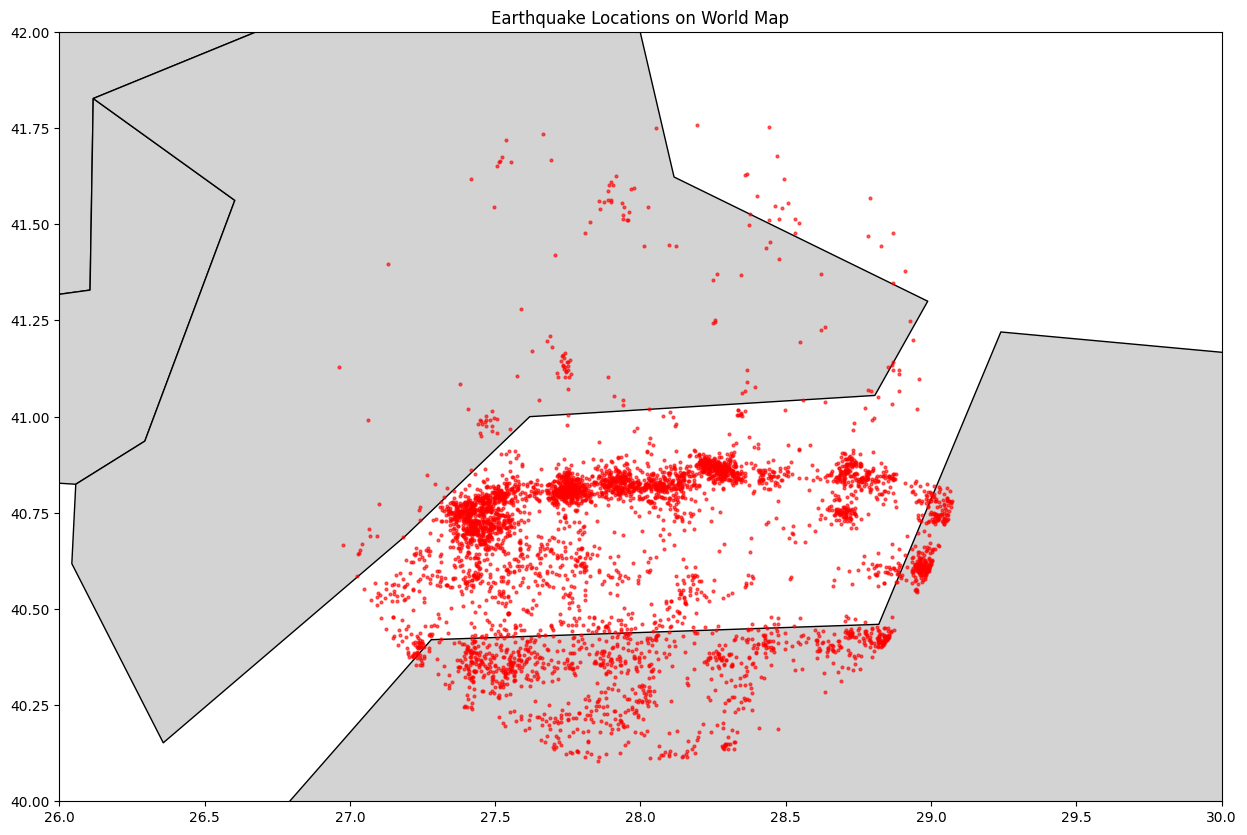

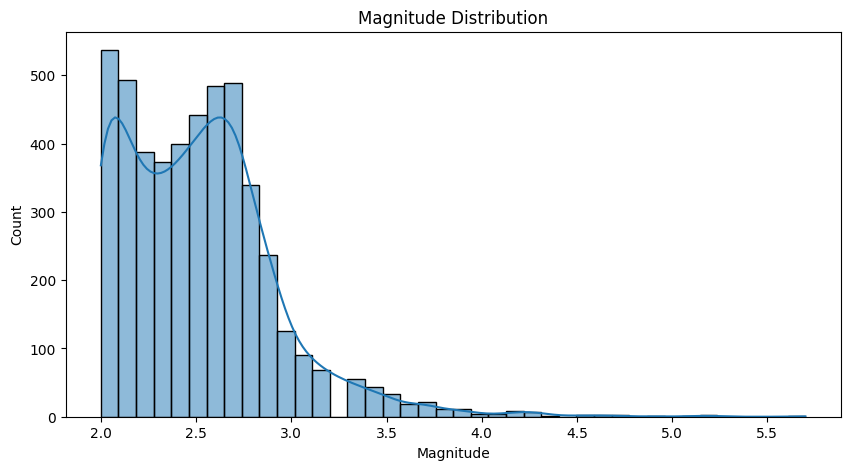

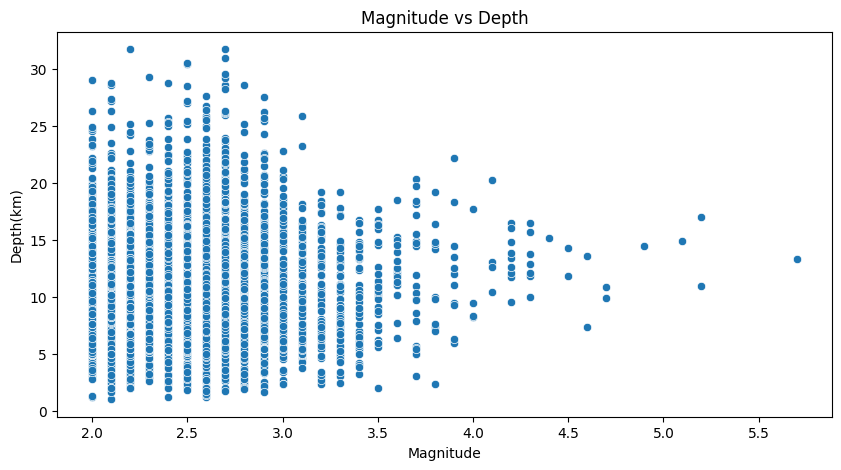

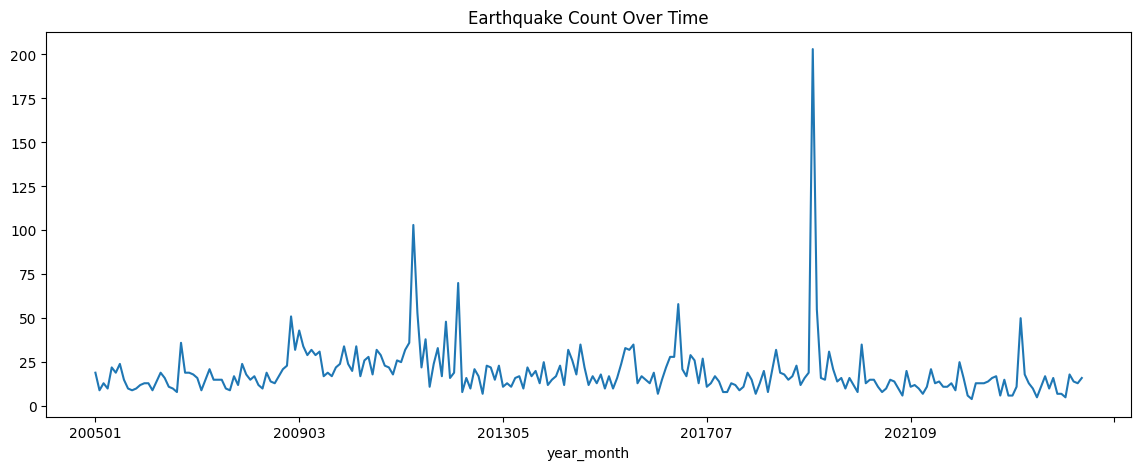

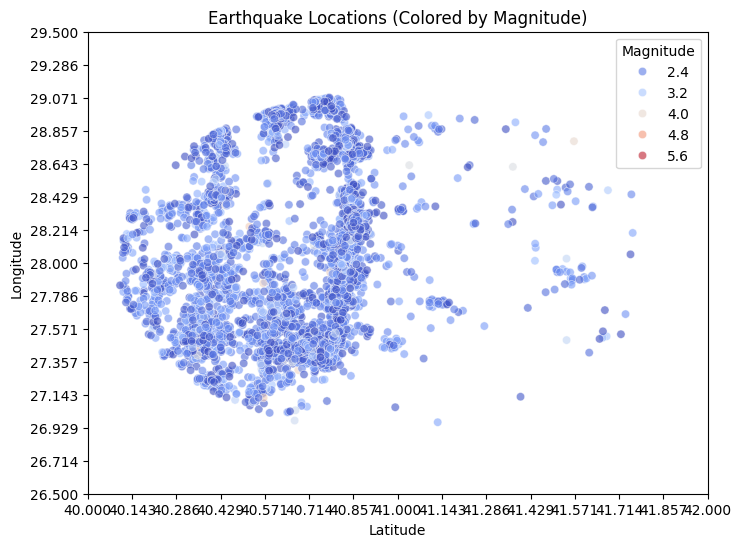

In [43]:
#EDA

#Displaying the data on a Globe, focused on the Istanbul area.
import geopandas as gpd
url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"
gdf = gpd.read_file(url)
earthquake_gdf = gpd.GeoDataFrame(
        merged_df,
        geometry=gpd.points_from_xy(merged_df['Longitude'], merged_df['Latitude']),
        crs="EPSG:4326"
        )

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
gdf.plot(ax=ax, color='lightgray', edgecolor='black')
earthquake_gdf.plot(ax=ax, marker='o', color='red', markersize=4, alpha=0.6)
plt.title("Earthquake Locations on World Map")
#Limits of Istanbul
min_lat = 40  # Minimum longitude
max_lat = 42   # Maximum longitude
min_lon = 26   # Minimum latitude
max_lon = 30    # Maximum latitude

ax.set_xlim(min_lon, max_lon)
ax.set_ylim(min_lat, max_lat)

plt.figure(figsize=(10, 5))
sns.histplot(merged_df["Magnitude"], bins=40, kde=True)
plt.title("Magnitude Distribution")

plt.figure(figsize=(10, 5))
sns.scatterplot(x="Magnitude", y="Depth(km)", data=merged_df)
plt.title("Magnitude vs Depth")

merged_df["year_month"] = merged_df["Year"]+merged_df["Month"]
monthly_counts = merged_df.groupby("year_month").size()

plt.figure(figsize=(14, 5))
monthly_counts.plot()
plt.title("Earthquake Count Over Time")

plt.figure(figsize=(8, 6))
sns.scatterplot(x="Latitude", y="Longitude", hue="Magnitude", data=merged_df, palette="coolwarm", alpha=0.6)
plt.title("Earthquake Locations (Colored by Magnitude)")
# Get the current axes
ax = plt.gca()

#Display settings
# Get the current tick locations
x_ticks = ax.get_xticks()
y_ticks = ax.get_yticks()
# Convert tick lists to NumPy arrays to use min/max
x_ticks_np = np.array(x_ticks)
y_ticks_np = np.array(y_ticks)
num_ticks = 15
# Select a subset of ticks to display
# np.linspace generates evenly spaced numbers over a specified interval
selected_x_ticks = np.linspace(x_ticks_np.min(), x_ticks_np.max(), num_ticks)
selected_y_ticks = np.linspace(y_ticks_np.min(), y_ticks_np.max(), num_ticks)
# Set the new tick locations
ax.set_xticks(selected_x_ticks)
ax.set_yticks(selected_y_ticks)
plt.show()

#**Feature Engineering**

Perhaps the most important step of this experiment was to understand sismic data and augment new features based on our understanding.

We augmented fundemantel features used in sisytemology (e.g, square of energy) as well as statistical features. By dividing the data into windows we augmented features like window mean, standart deviation, max value, elapsed time periods and more.

⭐Experimental Notes:

After a deep research on mathematical and pyhsical properities of such seismic data we realised that this is problem can't be modeled as a classical time-series analysis, because the data points are not dependent on the past trends. It is not a cumulative time series like we deal in stocks predicition.

**Next Steps**

With the help of mathematical fundations on signal models. We found new cool techniques we can use to extract new features.


*  FFT (Fast Fourier Transform): Finds dominant frequency content in magnitudes

* Wavelet Transformation: Multi-resolution energy representation. Uses both frequency and time domain.

* SVD (Singular Value Decomposition): Dimensionality signature of current window. Used to extract charateristic information (Latent Semantics) from a signal.



In [44]:
#Helper Funcitons

from scipy.fft import fft
import pywt
from numpy.linalg import svd

def get_fft_features(mags):
    fft_vals = np.abs(fft(mags - np.mean(mags)))
    top5 = np.sort(fft_vals)[-5:]
    return top5

def get_wavelet_features(mags):
    coeffs = pywt.wavedec(mags, 'db1', level=2)
    return [np.mean(np.abs(c)) for c in coeffs]

def get_svd_features(mags):
    L = 10  # SSA window length
    if len(mags) < L:
        return [0] * 5
    X = np.column_stack([mags[i:len(mags)-L+i+1] for i in range(L)])
    U, s, Vh = svd(X, full_matrices=False)
    return s[:5]  # top 5 singular values

#Explaination on why we seperated this way is below.
def risk_label(mag):
    if mag < 3.3:
        return 0  # no risk
    elif mag < 3.5:
        return 1  # low
    elif mag < 3.8:
        return 2  # medium
    else:
        return 3  # high


In [45]:
#Feature Engineering

# Rolling window: last 30 events
window = 30
features = []

for i in range(window, len(merged_df)):
    current_window = merged_df.iloc[i-window:i]
    future_window = merged_df.iloc[i:i+30] # may be short window at the end
    #label the last events as class 0, restore the presence of risk_bin = 0.
    if len(current_window) < window:
            continue  # just in case

    windowMax = future_window["Magnitude"].max()
    mags = current_window["Magnitude"]
    minMagnitude = mags.min()
    meanMagnitude = mags.mean()

    # Gutenberg-Richter b-value (MLE)
    bVal = (log10(np.e)) / (meanMagnitude - minMagnitude) if meanMagnitude > minMagnitude else 0
    aVal = np.log10(len(mags)) + bVal * meanMagnitude

    #Seismic energy √Σ(E)
    energy = 10 ** (1.5 * mags + 4.8)
    sqrtEnergy = sqrt(np.sum(energy))

    #TEMPORAL & STATISTICAL FEATURES
    times = current_window["DateTime"]
    T = (times.max() - times.min()).total_seconds()
    intervals = times.diff().dropna().dt.total_seconds()
    meanInterval = intervals.mean()
    coefficientVariation = intervals.std() / meanInterval if meanInterval > 0 else 0
    # Time since last event:
    if i > 0:
          timeSinceLast = (merged_df.iloc[i]["DateTime"] - merged_df.iloc[i-1]["DateTime"]).total_seconds()
    else:
          timeSinceLast = 0

    # Max magnitude in past 7 days:
    cutoff_time = merged_df.iloc[i]["DateTime"] - pd.Timedelta(days=7)
    last_7_days = merged_df[(merged_df["DateTime"] >= cutoff_time) & (merged_df["DateTime"] < merged_df.iloc[i]["DateTime"])]
    maxMagLast7Days = last_7_days["Magnitude"].max() if not last_7_days.empty else 0


    #Signal-processing features:
    #FFT, Wavelet, SSA/SVD
    fft_feats = get_fft_features(mags)
    wavelet_feats = get_wavelet_features(mags)
    svd_feats = get_svd_features(mags)

    #Seismic Law Features:
    # η: MSE deviation from G-R fit
    logN = np.log10(len(mags))
    predicted = bVal * mags + aVal
    eta = np.mean((predicted - logN)**2)

    # P(M >= 5.0)
    P_M_ge_5 = 10 ** (-bVal * (5.0 - minMagnitude)) if bVal > 0 else 0

    # ΔM = M_obs - (a / b)
    deltaM = mags.max() - (aVal / bVal) if bVal != 0 else 0

    features.append({
        "index": i,
        "DateTime": merged_df.iloc[i]["DateTime"],
        "windowMax": windowMax,
        "b_value": bVal,
        "a_value": aVal,
        "sqrtEnergy": sqrtEnergy,
        "cumulativeEnergy": np.sum(energy),
        "T": T,
        "timeSinceLast": timeSinceLast,
        "maxMagLast7Days": maxMagLast7Days,
        "meanInterval": meanInterval,
        "eta": eta,
        "P_M_ge_5": P_M_ge_5,
        "deltaM": deltaM,
        "coefficientVariation": coefficientVariation,
        "meanMagnitude": meanMagnitude,
        "minMagnitude": minMagnitude,
        **{f"fft_{j}": fft_feats[j] for j in range(len(fft_feats))},
        **{f"wavelet_{j}": wavelet_feats[j] for j in range(len(wavelet_feats))},
        **{f"svd_{j}": svd_feats[j] for j in range(len(svd_feats))}
        } )

feature_df = pd.DataFrame(features)
feature_df.dropna(inplace=True)
feature_df['risk_bin'] = feature_df['windowMax'].apply(risk_label)
feature_df.to_csv(os.path.join(base_path, "engineered_features.csv"), index=False)
feature_df.head()


,index,DateTime,windowMax,b_value,a_value,sqrtEnergy,cumulativeEnergy,T,timeSinceLast,maxMagLast7Days,...,fft_4,wavelet_0,wavelet_1,wavelet_2,svd_0,svd_1,svd_2,svd_3,svd_4,risk_bin
0,30,2020-01-31 20:36:15,3.9,1.009987,3.931390,1.195118e+06,1.428308e+12,2576848.0,20813.0,2.7,...,5.630710,4.80625,0.45625,0.372410,35.362346,4.548872,4.142191,2.901483,2.476487,3
1,31,2020-02-01 10:35:33,3.9,0.994568,3.900551,1.195155e+06,1.428397e+12,2539055.0,50358.0,2.7,...,5.475696,4.83750,0.40000,0.428978,35.120568,4.188950,4.079300,2.894146,2.418921,3
2,32,2020-02-02 00:57:43,3.9,1.059255,4.029925,1.194602e+06,1.427073e+12,2395351.0,51730.0,2.7,...,5.601279,4.79375,0.53125,0.344125,34.787424,4.134209,3.713347,2.888495,2.310873,3
3,33,2020-02-03 16:52:26,3.9,1.002218,3.915852,1.211512e+06,1.467761e+12,2349474.0,143683.0,3.9,...,5.946650,4.93750,0.27500,0.499689,34.562592,3.726417,3.710137,2.856952,1.989047,3
4,34,2020-02-04 06:27:09,3.9,1.009987,3.931390,1.211501e+06,1.467735e+12,2035150.0,48883.0,3.9,...,5.868766,4.92500,0.46250,0.381838,34.389146,3.721610,3.312518,2.298131,1.953765,3


⭐ Experiment Notes:
At this point, we realised it was almost impossible to divide the data into **balanced bins, while also them making sense magnitude wise.**


By a meticulous try-and-error and Quartile anaysis (Quartiles by definiton provide equal seperation on data) we were able to find a risk label seperation that created balanced bins, however they are perhaps again, not meaningful magnitude wise.

This is a huge issue especially for classification models. Even if we train the models on imbalanced bin classes, testing and evaluating them would be unlogical. Since test and train data can't keep the same distribution.

In [46]:
#Checking the bin balance
feature_df['risk_bin'].value_counts().sort_index()

,count
risk_bin,
0,1306
1,978
2,1133
3,1251


    # **Anomaly Detection**


    Problem Definition: Detect unusual patterns in earthquake sequences using unsupervised anomaly detection algorithms on engineered features.



    Models:

    * Isolation Forest:	Detects anomalies by isolating points

    * One-Class SVM:	Learns the boundary of "normal" data

    * LOF (Local Outlier Factor):	Detects samples that are isolated w.r.t. neighbors

In [47]:
#Anomally Detection Split and scale
from sklearn.preprocessing import StandardScaler

anomaly_features = feature_df.drop(columns=["risk_bin", "windowMax", "DateTime", "index"], errors="ignore")

scaler = StandardScaler()
X_anomaly = scaler.fit_transform(anomaly_features)


In [48]:
#Anomaly Detection Training
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor

# Isolation Forest
# Isolates samples randomly, anomalies are easier to isolate
iso_model = IsolationForest(contamination=0.05, random_state=42)
iso_preds = iso_model.fit_predict(X_anomaly)  # -1 for anomaly, 1 for normal

# One-Class SVM
#	Learns a tight boundary around normal data
ocsvm = OneClassSVM(nu=0.05, kernel="rbf", gamma='auto')
svm_preds = ocsvm.fit_predict(X_anomaly)

# LOF (non-predictive, unsupervised)
# Compares local density of a point to its neighbors
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
lof_preds = lof.fit_predict(X_anomaly)

feature_df["anomaly_iso"] = (iso_preds == -1).astype(int)
feature_df["anomaly_svm"] = (svm_preds == -1).astype(int)
feature_df["anomaly_lof"] = (lof_preds == -1).astype(int)


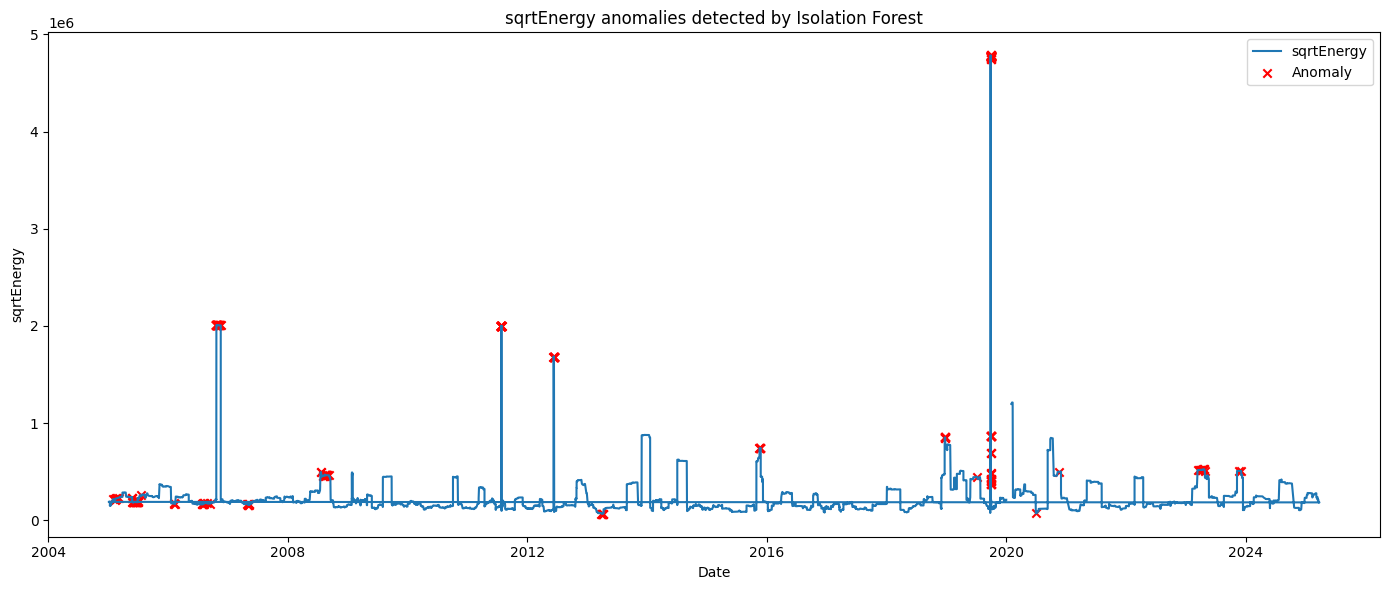

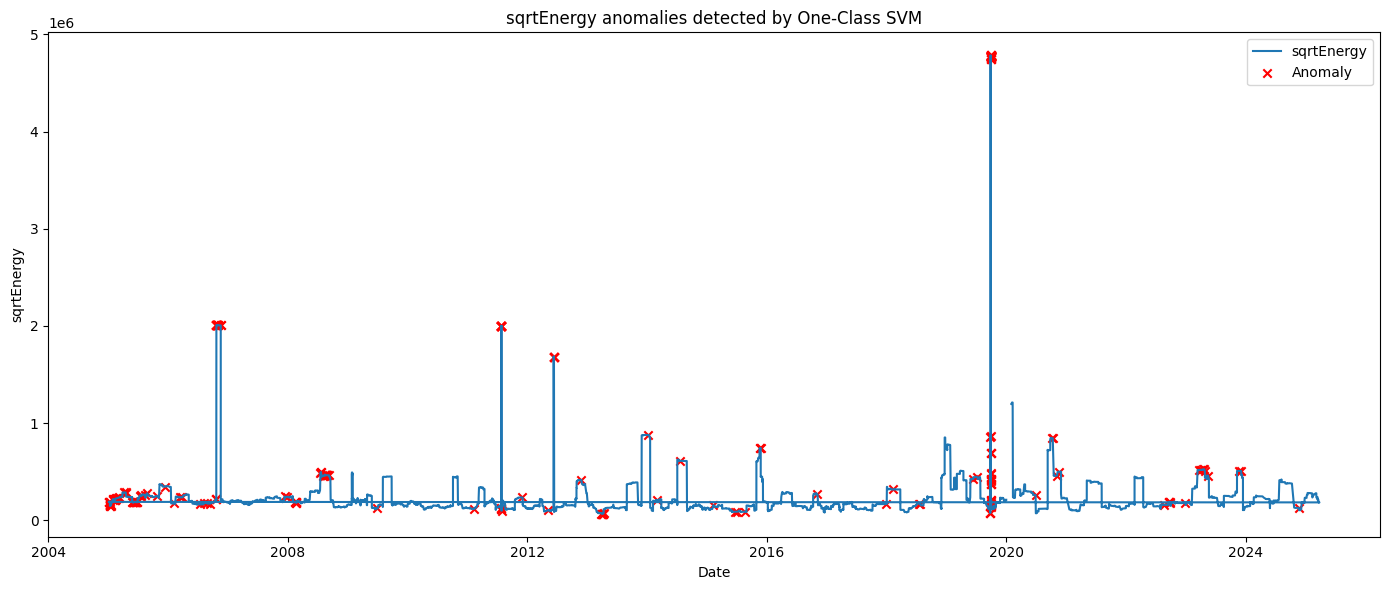

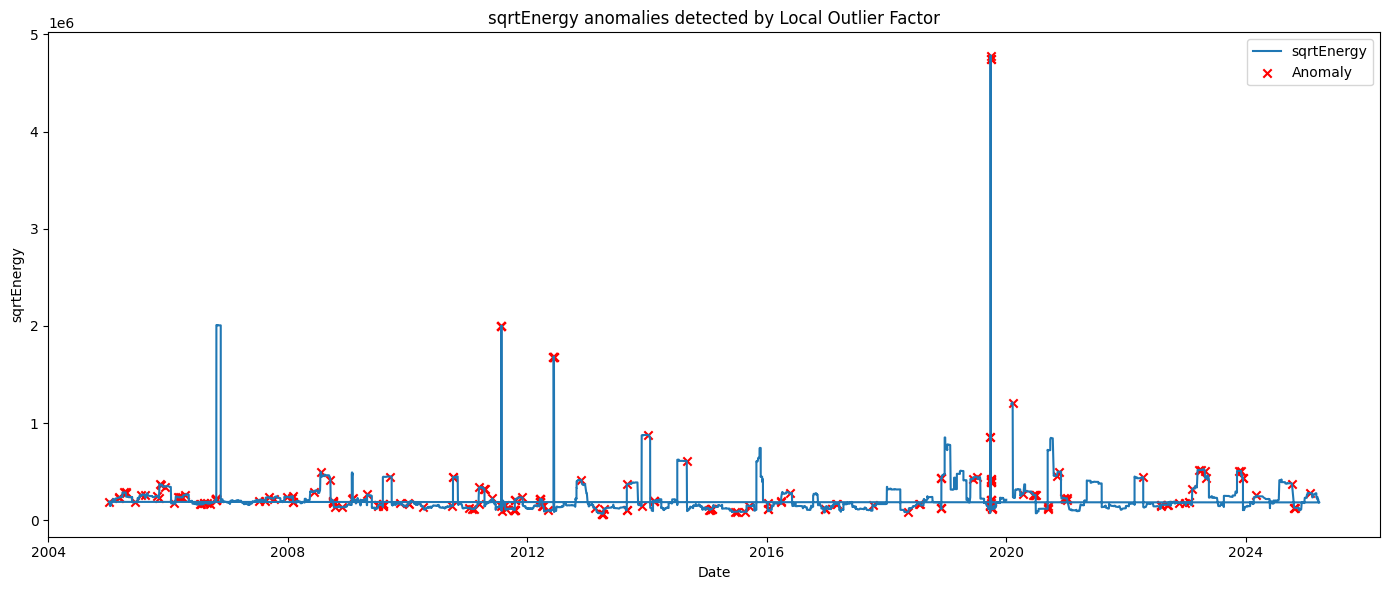

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

feature_df["DateTime"] = pd.to_datetime(feature_df["DateTime"])

# Plot func
def plot_anomalies(column, model_col, model_name):
    plt.figure(figsize=(14, 6))
    plt.plot(feature_df["DateTime"], feature_df[column], label=column)
    plt.scatter(feature_df["DateTime"][feature_df[model_col] == 1],
                feature_df[column][feature_df[model_col] == 1],
                color="red", label="Anomaly", marker="x")
    plt.title(f"{column} anomalies detected by {model_name}")
    plt.xlabel("Date")
    plt.ylabel(column)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot for each model
plot_anomalies("sqrtEnergy", "anomaly_iso", "Isolation Forest")
plot_anomalies("sqrtEnergy", "anomaly_svm", "One-Class SVM")
plot_anomalies("sqrtEnergy", "anomaly_lof", "Local Outlier Factor")

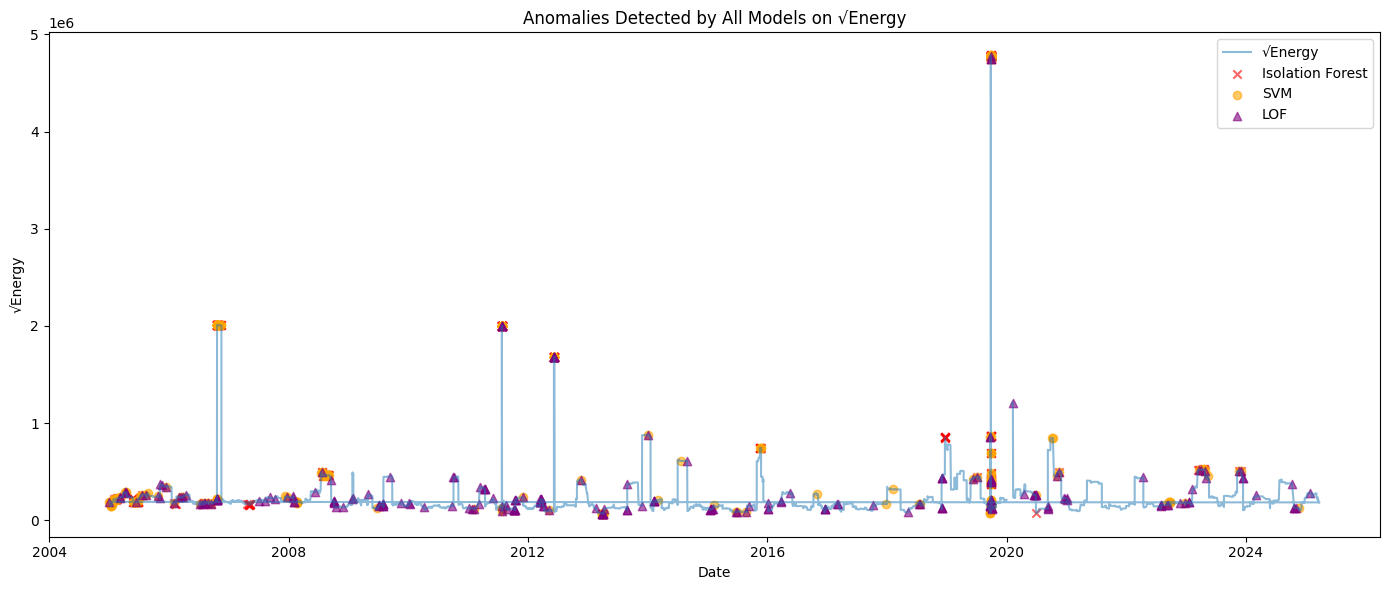

In [67]:
#Unified Anomaly Map
plt.figure(figsize=(14, 6))
plt.plot(feature_df["DateTime"], feature_df["sqrtEnergy"], label="√Energy", alpha=0.5)

# Overlay all three anomaly types
colors = { "Isolation Forest": "red", "SVM": "orange", "LOF": "purple" }
markers = { "Isolation Forest": "x", "SVM": "o", "LOF": "^" }

for model_col, model_name in [("anomaly_iso", "Isolation Forest"),
                               ("anomaly_svm", "SVM"),
                               ("anomaly_lof", "LOF")]:
    plt.scatter(
        feature_df["DateTime"][feature_df[model_col] == 1],
        feature_df["sqrtEnergy"][feature_df[model_col] == 1],
        color=colors[model_name],
        label=model_name,
        marker=markers[model_name],
        alpha=0.6
    )

plt.title("Anomalies Detected by All Models on √Energy")
plt.xlabel("Date")
plt.ylabel("√Energy")
plt.legend()
plt.tight_layout()
plt.show()


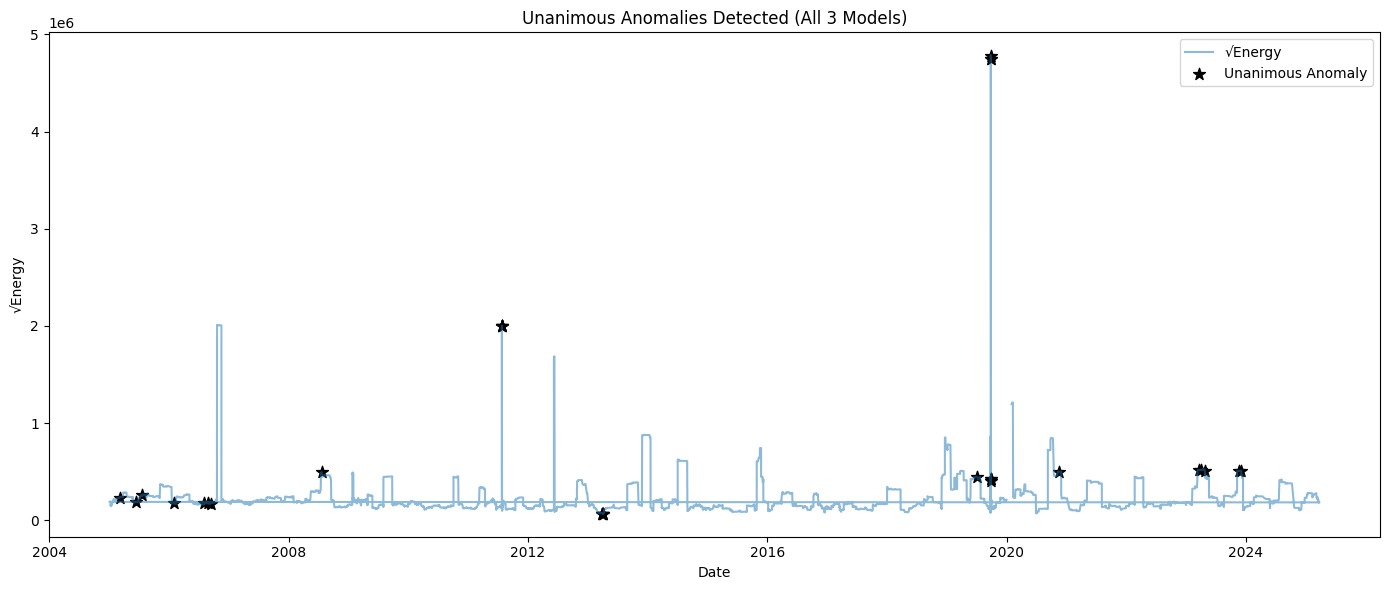

In [68]:
#Unanimous anomalies
plt.figure(figsize=(14, 6))
plt.plot(feature_df["DateTime"], feature_df["sqrtEnergy"], label="√Energy", alpha=0.5)
plt.scatter(feature_df["DateTime"][feature_df["unanimous_anomaly"] == 1],
            feature_df["sqrtEnergy"][feature_df["unanimous_anomaly"] == 1],
            color="black", label="Unanimous Anomaly", marker="*", s=80)
plt.title("Unanimous Anomalies Detected (All 3 Models)")
plt.xlabel("Date")
plt.ylabel("√Energy")
plt.legend()
plt.tight_layout()
plt.show()


##**Analyzing the Anomaly Results**

### **Time Series Plots**

These plots visualize how two important engineered features like `sqrtEnergy` and `b_value`evolve over time.

The markers indicate timestamps where the models detected anomalies. These markers help us visually assess:
- Whether anomalies tend to cluster in specific time periods.
- If they correspond to spikes or dips in energy. For example, if many anomalies appear during periods of high `sqrtEnergy`, this means the model is sensitive to bursts of seismic energy.

### **What the Anomaly Counts and Agreement Mean:**

We applied three different unsupervised anomaly detection algorithms. Each model uses different logic to define outliers.

- **Individual anomaly counts**:
  Shows the number of windows each model flagged as anomalies.

- **Agreed Anomalies:**
  - **30 data points** were flagged as anomalous by all models.  These points represent genuinely unique or rare patterns in the earthquake data.
  - These patterns may correlate with periods of increased or unusual seismic activity.
  - Their consistency across three models strengthens our confidence that these are meaningful outliers.

## **Summary:**

This section uses  **unsupervised anomaly detection** to identify windows of earthquake activity that stand out from the rest.

### **Can Anomaly Detection Models Be Used for Prediction Tasks?**

While unsupervised models don't directly predict future earthquake risk or magnitudes, they can still be used in powerful ways like:

- As New Features for Prediction: We can include the anomaly flags as features in a classification or regression model. The supervised model may learn that the presence of an anomaly is predictive of certain risk levels.

- As Early Alert Systems: These models can run in real-time on streaming data. If a new sequence is flagged as anomalous, it might act as a **weak** early warning.



#  **Model Selection & Training:**


Purpose of this study is to experiment with and compare available machine learning models based on their performance with seismic earthquake data.

We will use most suitable classical and deep learning models.

1.   Regression → predict windowMax
2.   Classification → bin windowMax into risk labels
3.   Deep Learning

Each method is implemented and observed in below cells.


##**1. Regression**


Problem Definition:  Predict the future of the graph?

Models:


1.   Ridge
2.   Lasso
3.   RF
4.   Gradient Boosting




⭐Experimental Notes: After implementing regression models, we realised they performed very poorly. Therefor the next cells are commented out to prevent unnecesarry steps. Also the test sets might cause unwanted errors on the classification section. It is better to just observe them instead of running.

In [50]:
#Data Split and Scalling for Regression
#Running this cell might  cause issues in the other cells, but to showcase the steps of the experiment we left the code in.
"""from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#Imabalanced!!!
X = feature_df.drop(['index', 'DateTime', 'windowMax', 'risk_bin'], axis=1)
y_reg = feature_df['windowMax']
y_clf = feature_df['risk_bin']

#Doesn't protect the distribition of the data on test and training set, Keeps the time order.
#Balance not required for Anomaly Detection, LSTM, DL. Anomaly Detection, LSTM, Deep Learning needs time-order.
X_train_reg, X_test_reg, y_reg_train, y_reg_test = train_test_split(X, y_reg, test_size=0.2, shuffle=False)
_, _, y_clf_train, y_clf_test = train_test_split(X, y_clf, test_size=0.2, shuffle=False)

scaler = StandardScaler()
X_train_scaled_reg = scaler.fit_transform(X_train_reg)
X_test_scaled_reg = scaler.transform(X_test_reg)"""


"from sklearn.model_selection import train_test_split\nfrom sklearn.preprocessing import StandardScaler\n\n#Imabalanced!!!\nX = feature_df.drop(['index', 'DateTime', 'windowMax', 'risk_bin'], axis=1)\ny_reg = feature_df['windowMax']\ny_clf = feature_df['risk_bin']\n\n#Doesn't protect the distribition of the data on test and training set, Keeps the time order.\n#Balance not required for Anomaly Detection, LSTM, DL. Anomaly Detection, LSTM, Deep Learning needs time-order.\nX_train_reg, X_test_reg, y_reg_train, y_reg_test = train_test_split(X, y_reg, test_size=0.2, shuffle=False)\n_, _, y_clf_train, y_clf_test = train_test_split(X, y_clf, test_size=0.2, shuffle=False)\n\nscaler = StandardScaler()\nX_train_scaled_reg = scaler.fit_transform(X_train_reg)\nX_test_scaled_reg = scaler.transform(X_test_reg)"

In [51]:
#Regression
#Running this cell might cause issues in the other cells, but to showcase the steps of the experiment we left the code in.
"""
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import joblib

models = {
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "RandomForest": RandomForestRegressor(),
    "GradientBoosting": GradientBoostingRegressor()
}

# Train, Predict, Evaluate
regression_results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train_scaled_reg, y_reg_train)
    preds = model.predict(X_train_scaled_reg)

    mae = mean_absolute_error(y_reg_test, preds)
    mse = mean_squared_error(y_reg_test, preds)
    r2 = r2_score(y_reg_test, preds)

    regression_results[name] = {
        "model": model,
        "MAE": mae,
        "MSE": mse,
        "R2": r2
    }

    print(f"{name} - MAE: {mae:.4f}, MSE: {mse:.4f}, R²: {r2:.4f}")

    # Optional: Plot predictions
    plt.figure(figsize=(10, 4))
    plt.plot(y_reg_test.values, label='Actual', alpha=0.7)
    plt.plot(preds, label='Predicted', alpha=0.7)
    plt.title(f"{name} - Predicted vs Actual Magnitude (Next 30 days Max)")
    plt.xlabel("Test Sample Index")
    plt.ylabel("Max Magnitude")
    plt.legend()
    plt.tight_layout()
    plt.show()
"""

'\nfrom sklearn.linear_model import Ridge, Lasso\nfrom sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor\nfrom sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score\nimport matplotlib.pyplot as plt\nimport joblib\n\nmodels = {\n    "Ridge": Ridge(),\n    "Lasso": Lasso(),\n    "RandomForest": RandomForestRegressor(),\n    "GradientBoosting": GradientBoostingRegressor()\n}\n\n# Train, Predict, Evaluate\nregression_results = {}\n\nfor name, model in models.items():\n    print(f"\nTraining {name}...")\n    model.fit(X_train_scaled_reg, y_reg_train)\n    preds = model.predict(X_train_scaled_reg)\n\n    mae = mean_absolute_error(y_reg_test, preds)\n    mse = mean_squared_error(y_reg_test, preds)\n    r2 = r2_score(y_reg_test, preds)\n\n    regression_results[name] = {\n        "model": model,\n        "MAE": mae,\n        "MSE": mse,\n        "R2": r2\n    }\n\n    print(f"{name} - MAE: {mae:.4f}, MSE: {mse:.4f}, R²: {r2:.4f}")\n\n    # Optional: Pl

##**2. Classification**


Problem Definition:

Models:


1. LogisticRegression
2. RandomForest
3. XGBoost
4. LightGBM

In [52]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import lightgbm as lgb


# Classification Split & Scale
X = feature_df.drop(columns=["index", "windowMax", "DateTime", "risk_bin"], errors="ignore") #Should I remove windowMax? Won't show some features
y_clf = feature_df["risk_bin"]

# Print class distribution before splitting
print("Full dataset class distribution:")
print(y_clf.value_counts().sort_index())

# Stratified split,  should preserve class proportions
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, test_idx in sss.split(X, y_clf):
    X_train_class, X_test_class = X.iloc[train_idx], X.iloc[test_idx]
    y_train_class, y_test_class = y_clf.iloc[train_idx], y_clf.iloc[test_idx]

# Print class distributions after split
print("\nTrain class distribution:")
print(y_train_class.value_counts().sort_index())

print("\nTest class distribution:")
print(y_test_class.value_counts().sort_index())

# Scale features
scaler = StandardScaler()
X_train_scaled_class = scaler.fit_transform(X_train_class)
X_test_scaled_class = scaler.transform(X_test_class)


Full dataset class distribution:
risk_bin
0    1306
1     978
2    1133
3    1251
Name: count, dtype: int64

Train class distribution:
risk_bin
0    1045
1     782
2     906
3    1001
Name: count, dtype: int64

Test class distribution:
risk_bin
0    261
1    196
2    227
3    250
Name: count, dtype: int64



LogisticRegression:

              precision    recall  f1-score   support

           0      0.407     0.609     0.488       261
           1      0.307     0.158     0.209       196
           2      0.381     0.233     0.290       227
           3      0.426     0.516     0.467       250

    accuracy                          0.398       934
   macro avg      0.380     0.379     0.363       934
weighted avg      0.385     0.398     0.375       934


RandomForest:

              precision    recall  f1-score   support

           0      0.918     0.943     0.930       261
           1      0.932     0.913     0.923       196
           2      0.946     0.921     0.933       227
           3      0.933     0.944     0.938       250

    accuracy                          0.931       934
   macro avg      0.932     0.930     0.931       934
weighted avg      0.932     0.931     0.931       934


XGBoost:

              precision    recall  f1-score   support

           0      0.895   

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



LightGBM:

              precision    recall  f1-score   support

           0      0.892     0.889     0.891       261
           1      0.892     0.888     0.890       196
           2      0.925     0.925     0.925       227
           3      0.913     0.920     0.916       250

    accuracy                          0.906       934
   macro avg      0.906     0.905     0.906       934
weighted avg      0.906     0.906     0.906       934


Model Comparison:
                Model  F1_macro
1        RandomForest  0.931036
2             XGBoost  0.920659
3            LightGBM  0.905516
0  LogisticRegression  0.363162

LightGBM Feature Importance:


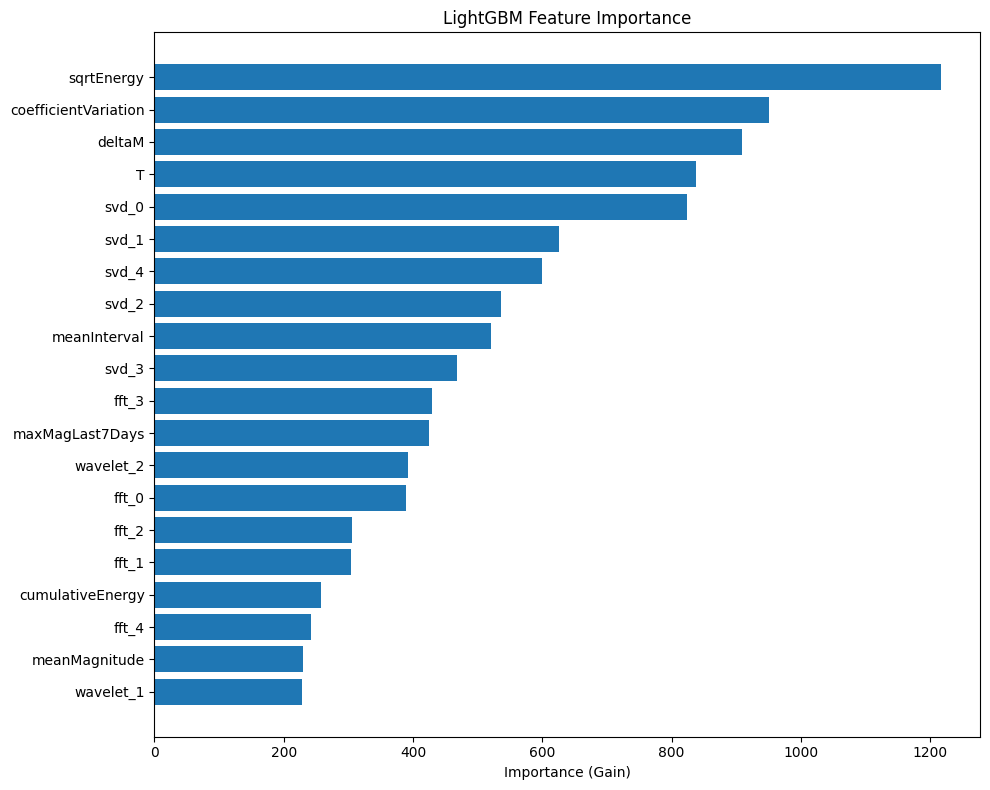

In [53]:
# Train Classifiers
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score

models = {
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "RandomForest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(eval_metric='mlogloss'),
    "LightGBM": LGBMClassifier()
}

results = []

for name, model in models.items():
    try:
        model.fit(X_train_scaled_class, y_train_class)
        y_pred_class = model.predict(X_test_scaled_class)
        print(f"\n{name}:\n")
        print(classification_report(y_test_class, y_pred_class, digits=3))

        f1 = f1_score(y_test_class, y_pred_class, average='macro')
        results.append({"Model": name, "F1_macro": f1})
    except ValueError as e:
        print(f"{name} failed: {e}")
        results.append({"Model": name, "F1_macro": None})

# Results Summary
results_df = pd.DataFrame(results).sort_values("F1_macro", ascending=False)
print("\nModel Comparison:")
print(results_df)

#Light Gradient Boost Feature Importance
print("\nLightGBM Feature Importance:")
# Get the feature names
feature_names = X_train_class.columns.tolist()

# Get feature importances from the trained LightGBM model
if "LightGBM" in models:
    lgbm_model = models["LightGBM"]
    try:
        # Get feature importance and sort them
        importance = lgbm_model.feature_importances_
        feature_importance = sorted(zip(feature_names, importance), key=lambda x: x[1], reverse=True)

        # Select top features if max_num_features is specified
        max_num_features = 20
        if max_num_features is not None and max_num_features < len(feature_importance):
            feature_importance = feature_importance[:max_num_features]

        # Separate names and values for plotting
        names, values = zip(*feature_importance)

        plt.figure(figsize=(10, len(names) * 0.4))
        plt.barh(names, values)
        plt.title("LightGBM Feature Importance")
        plt.xlabel("Importance (Gain)")
        plt.gca().invert_yaxis() # Invert y-axis to have the most important feature at the top
        plt.tight_layout()
        plt.show()
    except AttributeError:
        print("Could not get feature importance from LightGBM model.")

#No need to save the models, they are very light to train
"""#Saving the Classification Models
joblib.dump(model, "/content/drive/MyDrive/classification.pkl")"""

# Save CSV
results_df.to_csv("model_comparison_classification.csv", index=False)


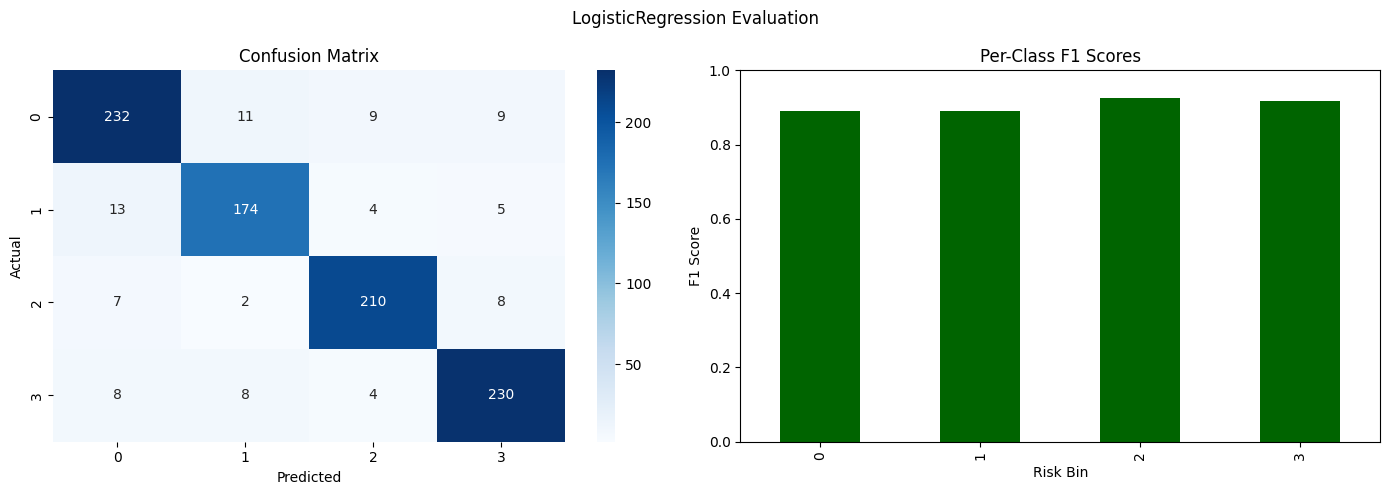

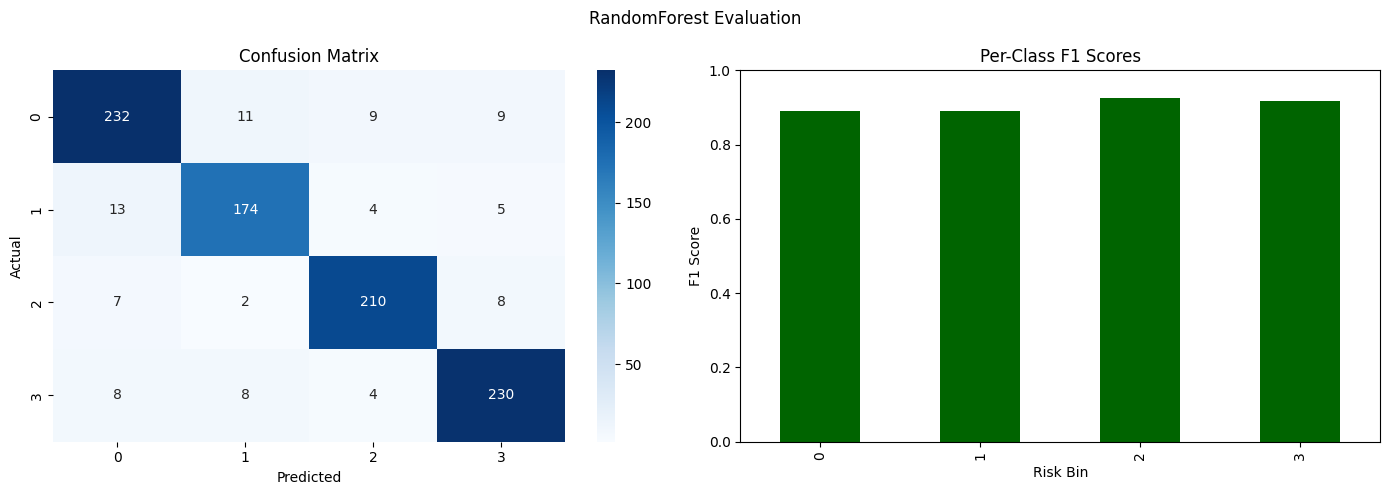

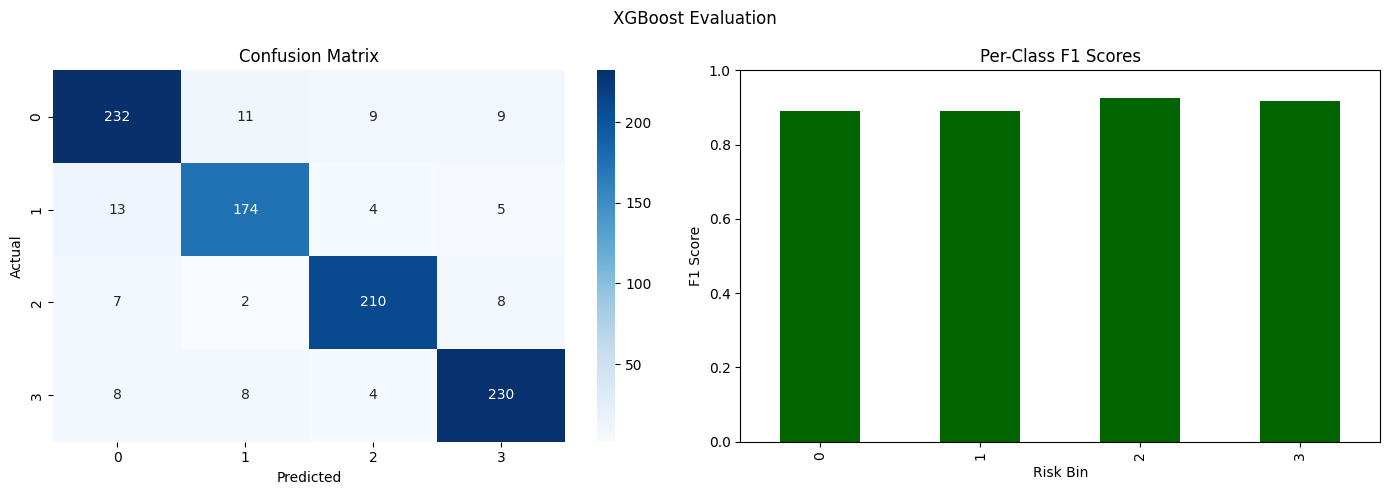

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


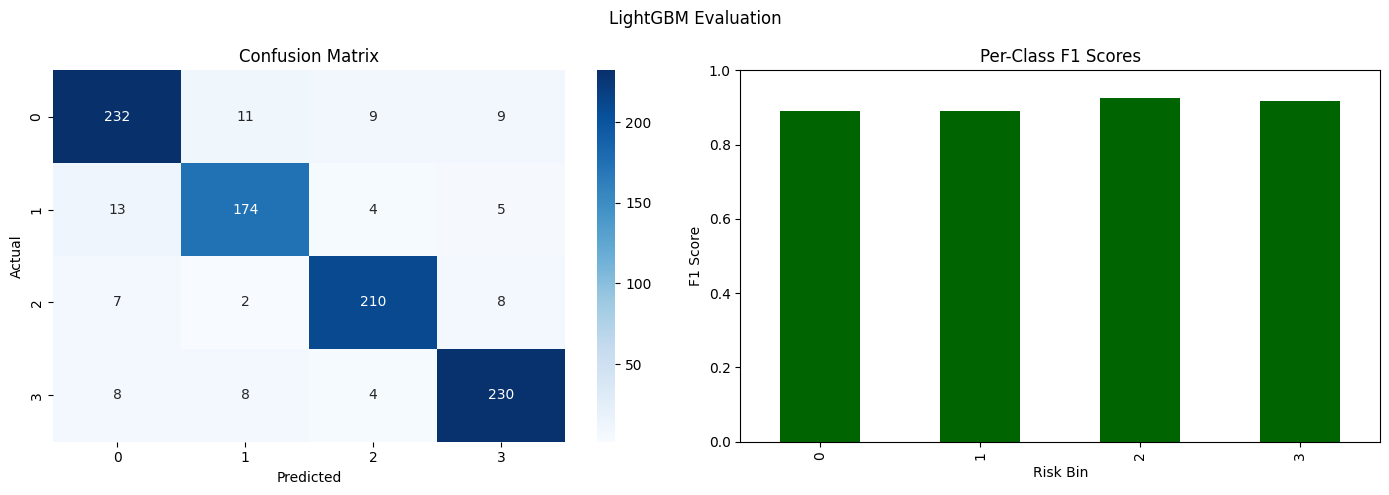

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Create confusion matrix and per-class F1 plots
for name, model in models.items():
    y_pred = model.predict(X_test_scaled_class)
    cm = confusion_matrix(y_test_class, y_pred_class)
    report = classification_report(y_test_class, y_pred_class, output_dict=True)

    f1_per_class = {k: v["f1-score"] for k, v in report.items() if k.isdigit()}
    f1_df = pd.DataFrame.from_dict(f1_per_class, orient='index', columns=['F1-score'])

    fig, ax = plt.subplots(1, 2, figsize=(14, 5))
    fig.suptitle(f"{name} Evaluation")

    # Confusion Matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax[0])
    ax[0].set_title("Confusion Matrix")
    ax[0].set_xlabel("Predicted")
    ax[0].set_ylabel("Actual")

    # Per-Class F1 Score Bar Plot
    f1_df.plot(kind='bar', legend=False, ax=ax[1], color='darkgreen')
    ax[1].set_title("Per-Class F1 Scores")
    ax[1].set_xlabel("Risk Bin")
    ax[1].set_ylabel("F1 Score")
    ax[1].set_ylim(0, 1)

    plt.tight_layout()
    plt.show()


##**3. Deep Learning**


Problem Definition:

Models:


1.   LSTM
2.   Multilayer Perceptron (MLP)

In [55]:
# Prepare Input Data for Deep Learning

# For MLP or TabNet we need tabular features
# Input shape = (n_samples, n_features)
# We already have this with X_train and y_train

# For LSTM we need sequential windows
# Input shape = (n_samples, sequence_length, n_features)
# Each sample is a time window (e.g., 10 steps) and the label is the risk_bin after the window

import numpy as np
from sklearn.preprocessing import LabelEncoder

#Creating sequnce windows for LSTM
def create_lstm_sequences(df, feature_columns, label_column, time_steps=10):
    X_seq, y_seq = [], []
    for i in range(len(df) - time_steps):
        seq_x = df[feature_columns].iloc[i:i+time_steps].values
        seq_y = df[label_column].iloc[i+time_steps]
        X_seq.append(seq_x)
        y_seq.append(seq_y)
    return np.array(X_seq), np.array(y_seq)

feature_columns = X_train_class.columns.tolist()
label_column = 'risk_bin'

# Combine train and test temporarily to generate sequential windows
df_for_seq = feature_df.copy()
label_encoder = LabelEncoder()
# Fit the encoder on the original y_clf Series to capture all possible classes
label_encoder.fit(y_clf)
df_for_seq['risk_bin'] = label_encoder.transform(df_for_seq['risk_bin'])

X_lstm, y_lstm = create_lstm_sequences(df_for_seq, feature_columns, label_column, time_steps=10)


# Split again into train/test for LSTM
split_idx = int(0.8 * len(X_lstm))
X_lstm_train, X_lstm_test = X_lstm[:split_idx], X_lstm[split_idx:]
y_lstm_train, y_lstm_test = y_lstm[:split_idx], y_lstm[split_idx:]

# Get number of features
n_classes = len(np.unique(y_train_class))
n_features = X_train_class.shape[1]

Epoch 1/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.3030 - loss: 1.3950 - val_accuracy: 0.3574 - val_loss: 1.3177
Epoch 2/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3675 - loss: 1.3044 - val_accuracy: 0.3869 - val_loss: 1.2910
Epoch 3/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3940 - loss: 1.2583 - val_accuracy: 0.4190 - val_loss: 1.2566
Epoch 4/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4391 - loss: 1.2322 - val_accuracy: 0.4351 - val_loss: 1.2439
Epoch 5/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4564 - loss: 1.2057 - val_accuracy: 0.4458 - val_loss: 1.2173
Epoch 6/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4784 - loss: 1.1868 - val_accuracy: 0.4324 - val_loss: 1.2203
Epoch 7/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4717 - loss: 1.1815 - val_accuracy: 0.4552 - val_loss: 1.1866
Epoch 8/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5206 - loss: 1.1361 - val_accuracy: 0.4739 - val_loss:

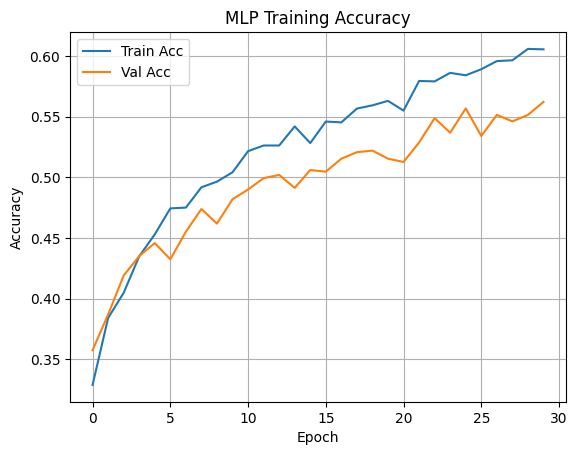

In [56]:
#MLP Training and Evaluation

from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

# 1. Scale inputs
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_class)
X_test_scaled = scaler.transform(X_test_class)

# 2. One-hot encode targets
y_train_cat = to_categorical(y_train_class)
y_test_cat = to_categorical(y_test_class)

# 3. Compute class weights
import numpy as np
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_class), y=y_train_class)
class_weights_dict = dict(enumerate(class_weights))

# 4. Define model
mlp_model = Sequential([
    Input(shape=(X_train_class.shape[1],)),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(n_classes, activation='softmax')
])

mlp_model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

# 5. Train
history = mlp_model.fit(X_train_scaled, y_train_cat,
                        epochs=30,
                        batch_size=32,
                        validation_split=0.2,
                        class_weight=class_weights_dict,
                        verbose=1)

# 6. Evaluate
y_mlp_pred = mlp_model.predict(X_test_scaled)
y_mlp_pred_classes = np.argmax(y_mlp_pred, axis=1)

print("Classification Report (MLP):")
print(classification_report(y_test_class, y_mlp_pred_classes))

# Plot training history
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('MLP Training Accuracy')
plt.legend()
plt.grid(True)
plt.show()



**MLP Summary:**

MLP accuracy is ~56% (vs. random 25%), this means it’s learning some structure in the data.

Precision/recall is decent and balanced across classes, all this is a good sign.

This means the Baseline is successful, however we should/could tune hyperparameters or add regularization for better results.


Epoch 1/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.4055 - loss: 1.3053 - val_accuracy: 0.2212 - val_loss: 1.7590
Epoch 2/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5842 - loss: 1.0405 - val_accuracy: 0.1769 - val_loss: 2.1062
Epoch 3/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6604 - loss: 0.8650 - val_accuracy: 0.1810 - val_loss: 2.2809
Epoch 4/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7275 - loss: 0.7192 - val_accuracy: 0.1836 - val_loss: 2.5394
Epoch 5/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7576 - loss: 0.6434 - val_accuracy: 0.1997 - val_loss: 2.5897
Epoch 6/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8011 - loss: 0.5294 - val_accuracy: 0.2011 - val_loss: 2.9550
Epoch 7/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8226 - loss: 0.4740 - val_accuracy: 0.2064 - val_loss: 3.1731
Epoch 8/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8521 - loss: 0.3897 - val_accuracy: 0.1836 - val_

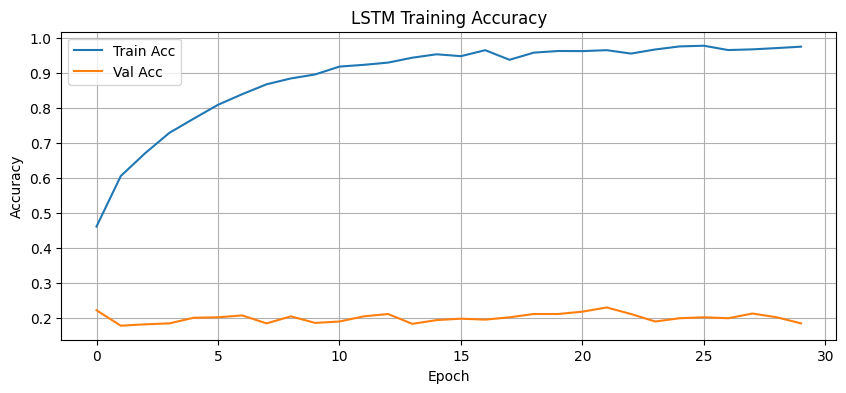

In [58]:
# LSTM Training and Evaluation
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np

#Scale each feature independently
n_timesteps = X_lstm_train.shape[1]
n_features = X_lstm_train.shape[2]

scaler = StandardScaler()
X_lstm_train_scaled = scaler.fit_transform(X_lstm_train.reshape(-1, n_features)).reshape(-1, n_timesteps, n_features)
X_lstm_test_scaled  = scaler.transform(X_lstm_test.reshape(-1, n_features)).reshape(-1, n_timesteps, n_features)

# One-hot encode the labels
y_lstm_train_cat = to_categorical(y_lstm_train)
y_lstm_test_cat = to_categorical(y_lstm_test)

#Compute class weights
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(y_lstm_train),
                                     y=y_lstm_train)
class_weights_dict = dict(enumerate(class_weights))

#Define the LSTM model
lstm_model = Sequential([
    Input(shape=(n_timesteps, n_features)),
    LSTM(64),
    Dense(32, activation='relu'),
    Dense(n_classes, activation='softmax')
])

lstm_model.compile(optimizer=Adam(learning_rate=0.001),
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

# Train
lstm_history = lstm_model.fit(X_lstm_train_scaled, y_lstm_train_cat,
                              epochs=30,
                              batch_size=32,
                              validation_split=0.2,
                              class_weight=class_weights_dict,
                              verbose=1)

#Evaluate
y_lstm_pred = lstm_model.predict(X_lstm_test_scaled)
y_lstm_pred_classes = np.argmax(y_lstm_pred, axis=1)

print("Classification Report (LSTM):")
print(classification_report(y_lstm_test, y_lstm_pred_classes))

#Plot training accuracy
plt.figure(figsize=(10, 4))
plt.plot(lstm_history.history['accuracy'], label='Train Acc')
plt.plot(lstm_history.history['val_accuracy'], label='Val Acc')
plt.title('LSTM Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


**LSTM Summary:**
Results show massive overfitting based on train_acc = 0.97, val_acc = 0.17.

Model seems to be confused and lost on unseen data because the
Loss on val = 6.42.


Very poor accuracy,  Test accuracy = 0.20.	Even worse than random guessing. 😞



⭐Experiment Notes:
What went wrong with LSTM?


Although we are not sure, we do have a theory:



*   Data Isn’t Temporal Enough: LSTM assumes meaningful order over time, not just features.  feeding LSTM with non-temporal tabular data shaped to (timesteps, features), it’s fake temporal, not suitable for LSTM.


What to do next? We can shuffle the data to make sure it has no temporal meaning:


Epoch 1/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.3433 - loss: 1.3391 - val_accuracy: 0.1501 - val_loss: 1.7984
Epoch 2/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5440 - loss: 1.1235 - val_accuracy: 0.1515 - val_loss: 2.1003
Epoch 3/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6453 - loss: 0.9556 - val_accuracy: 0.1850 - val_loss: 2.2648
Epoch 4/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6866 - loss: 0.8262 - val_accuracy: 0.2292 - val_loss: 2.6439
Epoch 5/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7355 - loss: 0.7159 - val_accuracy: 0.2145 - val_loss: 2.8082
Epoch 6/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7850 - loss: 0.5934 - val_accuracy: 0.2373 - val_loss: 2.8240
Epoch 7/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7921 - loss: 0.5293 - val_accuracy: 0.2158 - val_loss: 3.1116
Epoch 8/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8316 - loss: 0.4732 - val_accuracy: 0.1769 - val_l

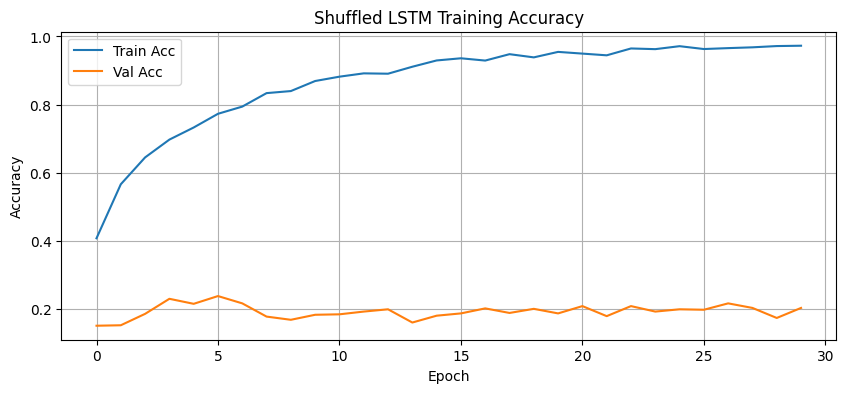

In [59]:
# LSTM with Time Step Shuffling
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np

# --- Step 1: Shuffle time steps within each sequence ---
X_lstm_train_shuffled = X_lstm_train.copy()
X_lstm_test_shuffled = X_lstm_test.copy()

for i in range(X_lstm_train_shuffled.shape[0]):
    np.random.shuffle(X_lstm_train_shuffled[i])  # shuffle time steps

for i in range(X_lstm_test_shuffled.shape[0]):
    np.random.shuffle(X_lstm_test_shuffled[i])  # shuffle time steps

# --- Step 2: Standard scaling ---
n_timesteps = X_lstm_train.shape[1]
n_features = X_lstm_train.shape[2]

scaler = StandardScaler()
X_lstm_train_scaled = scaler.fit_transform(X_lstm_train_shuffled.reshape(-1, n_features)).reshape(-1, n_timesteps, n_features)
X_lstm_test_scaled  = scaler.transform(X_lstm_test_shuffled.reshape(-1, n_features)).reshape(-1, n_timesteps, n_features)

# --- Step 3: One-hot encode labels ---
y_lstm_train_cat = to_categorical(y_lstm_train)
y_lstm_test_cat = to_categorical(y_lstm_test)

# --- Step 4: Class weights ---
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(y_lstm_train),
                                     y=y_lstm_train)
class_weights_dict = dict(enumerate(class_weights))

# --- Step 5: Define model ---
lstm_model = Sequential([
    Input(shape=(n_timesteps, n_features)),
    LSTM(64),
    Dense(32, activation='relu'),
    Dense(n_classes, activation='softmax')
])

lstm_model.compile(optimizer=Adam(learning_rate=0.001),
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

# --- Step 6: Train ---
lstm_history = lstm_model.fit(X_lstm_train_scaled, y_lstm_train_cat,
                              epochs=30,
                              batch_size=32,
                              validation_split=0.2,
                              class_weight=class_weights_dict,
                              verbose=1)

# --- Step 7: Evaluate ---
y_lstm_pred = lstm_model.predict(X_lstm_test_scaled)
y_lstm_pred_classes = np.argmax(y_lstm_pred, axis=1)

print("Classification Report (Shuffled LSTM):")
print(classification_report(y_lstm_test, y_lstm_pred_classes))

# --- Step 8: Plot training accuracy ---
plt.figure(figsize=(10, 4))
plt.plot(lstm_history.history['accuracy'], label='Train Acc')
plt.plot(lstm_history.history['val_accuracy'], label='Val Acc')
plt.title('Shuffled LSTM Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


 ⭐Experiment Notes


Interpretation of results of the LSTM after Shuffling:

Each case had very low generalization in both cases. Both models perform very well on training (almost 100%) and very poorly on validation/test, meaning extream overfitting. This means the LSTM is memorizing the training data and not actually learning useful patterns.

What did shuffling prove?
Shuffling destroys temporal order within each sequence. Yet, our test accuracy increased after shuffling. Therefor there is likely no meaningful temporal structure in our features (or perhaps, whatever time order exists is not consistent enough for the LSTM to learn from.). This could be a result of feeding LSTM a dataset that behaves like tabular data (just features across timesteps), without a strong sequential dependency.


**Next Steps:**
We should stick to a non-sequential model like MLP or tree-based (Random Forest or XGBoost, like we did in the sections above)
